Clean the smiles from Colin et al's csv files from v1.0.1: https://zenodo.org/record/3715478#.YFfpgh0pDUI

In [1]:
import copy
import pandas as pd

from rmgpy.molecule.molecule import *
from rmgpy.species import Species
from rdkit import Chem
from rdkit.Chem.rdchem import ChiralType
from rdkit.Chem import AllChem
from rdkit.Chem.rdchem import AtomValenceException
from rdkit.Geometry import Point3D
from rdkit.six import StringIO
from typing import List, Tuple, Union

from arc.species import ARCSpecies
from arc.reaction import ARCReaction

from arc.species.converter import (check_isomorphism,
                                   molecules_from_xyz,
                                   str_to_xyz,
                                   xyz_to_str,
                                   xyz_to_x_y_z,
                                   xyz_to_xyz_file_format,
                                   xyz_to_dmat,
                                   xyz_to_coords_list,
                                  )
from arc.parser import parse_xyz_from_file
from IPython.display import display
import arc
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

### Define helper functions

In [3]:
def look_for_adjacent_charges(smiles, idx):
    # create mol from original smiles
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    out = AllChem.EmbedMolecule(mol, maxAttempts=5000)
    # set label on H atoms
#     print([a.SetAtomMapNum(a.GetIdx()) for a in mol.GetAtoms()])
#     print([a.SetAtomMapNum(a.GetIdx()+1) for a in mol.GetAtoms()])
    [a.SetAtomMapNum(a.GetIdx()+1) for a in mol.GetAtoms()]
    
    index_str = f'{idx:06}'  # convert to formatted string
    if out != 0:
        print(f'ERROR: Could not embed reactant for rxn {index_str}: {smiles} !!!!!!!\n')
        failed_embedding_idx.append(index_str)
    
    for i, b in enumerate(mol.GetBonds()):
        ac1 = b.GetBeginAtom().GetFormalCharge()
        ac2 = b.GetEndAtom().GetFormalCharge()
        
        # detects radical electrons or formal charges on neighboring atoms    
        if abs(ac1) + abs(ac2) == 2:
            print(f'rxn {index_str} with smiles {smiles} had neighboring formal charges')
            display(mol)
            b.GetBeginAtom().SetFormalCharge(0)
            b.GetEndAtom().SetFormalCharge(0)
            new_mol = Chem.EditableMol(mol)
            a1 = b.GetBeginAtomIdx()
            a2 = b.GetEndAtomIdx()
            new_mol.RemoveBond(a1, a2)
            new_mol.AddBond(a1, a2, Chem.BondType.DOUBLE)

            new_mol = new_mol.GetMol()
            # set label on H atoms
#             print([a.SetAtomMapNum(a.GetIdx()) for a in new_mol.GetAtoms()])
#             print([a.SetAtomMapNum(a.GetIdx()+1) for a in new_mol.GetAtoms()])
            [a.SetAtomMapNum(a.GetIdx()+1) for a in new_mol.GetAtoms()]
            new_smi = Chem.MolToSmiles(new_mol)
            print(f'Propose adding a double bond instead as {new_smi}')
            display(new_mol)
            print('*'*90)
            
            return idx

### Read Colin's original data

In [5]:
b97d3 = 'b97d3_original.csv'
df_colin = pd.read_csv(b97d3)
df_colin

,idx,rsmi,psmi,ea,dh
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]1([H:7])([H:8])/[C:2](=[N:3]\[H:9])[N:6]1...,77.689287,45.532073
1,1,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2](=[N:3][O-:4])[N+:6]#[N:5])([H:7])(...,45.367710,19.774235
2,2,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1](=[C:2]1[N-:3][O+:4]=[N:5][N:6]1[H:9])([H...,84.713035,54.584197
3,3,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]([C:2]#[N:3])([H:7])([H:8])[H:9].[O:4]=[N...,24.035982,-15.011997
4,4,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1](=[C:2]1[N:3]([H:8])[O:4][N:5]=[N:6]1)([H...,77.679891,34.331205
...,...,...,...,...,...
16360,16360,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C-:6]#[O+:7].[C:1]([C:2]([O:3][H:12])([H:11])...,81.109624,26.321959
16361,16361,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1](=[C:2]([C:4]([O:5][C:6](=[O:7])[H:15])([...,60.177990,16.450943
16362,16362,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:2](=[O:3])[C:4]([O:5][C:6](=[O:7])[H:...,77.095485,6.748584
16363,16363,[C:1]([C@@:2]([O:3][H:12])([C:4]([O:5][C:6](=[...,[C:1]([C:2](=[O:3])[C:4]([H:11])([H:13])[H:14]...,50.491283,-18.449602


In [6]:
df_colin.rsmi.unique().shape

(1161,)

In [7]:
df_colin_unique = df_colin.drop_duplicates(subset=['rsmi'])
df_colin_unique

,idx,rsmi,psmi,ea,dh
0,0,[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8...,[C:1]1([H:7])([H:8])/[C:2](=[N:3]\[H:9])[N:6]1...,77.689287,45.532073
6,6,[C:1]([O:2][C:3]([C:4]([O:5][H:13])([H:11])[H:...,[C:1]([O:2][H:13])([H:6])([H:7])[H:8].[C:3]1([...,60.267853,20.541346
13,13,[O:1]=[C:2]([N:3]=[N+:4]=[N-:5])[H:6],[N:3](=[N+:4]=[N-:5])[H:6].[O+:1]#[C-:2],53.326162,9.739570
17,17,[C:1]1([H:7])([H:8])[C@@:2]2([H:9])[C:3]([H:10...,[C:1]1([H:8])=[C:2]([H:9])[C:3]([H:10])([H:11]...,80.954368,8.282420
26,26,[O:1]([c+:2]1[n-:3][c:4]([H:8])[n:5][n:6]1[H:9...,[O:1](/[C:2]([N:3]1[C:4]([H:8])=[N:5]1)=[N:6]\...,79.712795,63.447132
...,...,...,...,...,...
16264,16264,[C:1]([C@@:2]([O:3][H:11])([C:4]#[C:5][H:12])[...,[C:1]([C:2]([C:4]#[C:5][H:12])=[C:6]=[N:7][O:3...,74.010124,38.890577
16275,16275,[O:1]([C@@:2]1([H:9])[C:3]([H:10])([H:11])[C@:...,[O:1](/[C:2](=[C:6](/[C:5]([C:4]([C:3]([H:10])...,62.974337,-28.700626
16300,16300,[C:1]([C@@:2]1([H:11])[C@@:3]2([H:12])[C:4]([H...,[C:1]([C@@:2]1([H:11])[C:3]([H:12])([H:17])[C:...,63.950458,51.551314
16328,16328,[N:1]([c:2]1[c:3]([H:10])[n:4]([H:11])[c:5]([O...,[N:1]([C:2]1=[C-:3][N+:4]([H:10])([H:11])[C:5]...,86.155073,80.015311


rxn 000013 with smiles [O:1]=[C:2]([N:3]=[N+:4]=[N-:5])[H:6] had neighboring formal charges


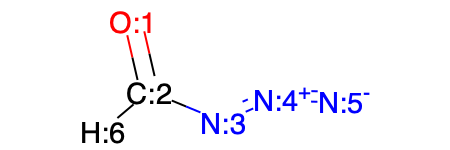

Propose adding a double bond instead as [O:1]=[C:2]([N:3]=[N:4]=[N:5])[H:6]


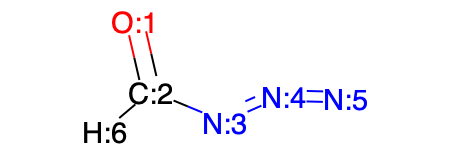

******************************************************************************************
rxn 000026 with smiles [O:1]([c+:2]1[n-:3][c:4]([H:8])[n:5][n:6]1[H:9])[H:7] had neighboring formal charges


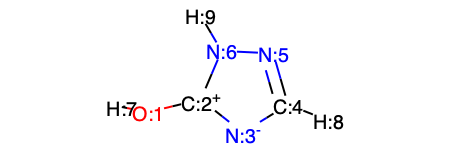

Propose adding a double bond instead as [O:1]([c:2]1[n:6]([H:9])[n:5][c:4]([H:8])[n:3]=1)[H:7]


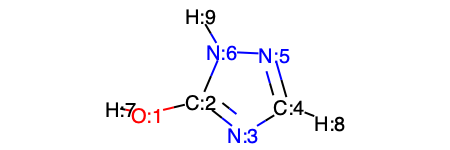

******************************************************************************************
rxn 002861 with smiles [N:1]([c+:2]1[n-:3][c:4]([H:9])[n:5][o:6]1)([H:7])[H:8] had neighboring formal charges


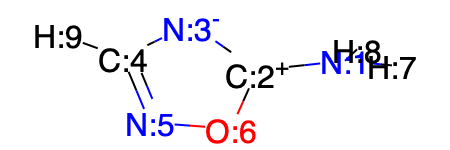

Propose adding a double bond instead as [N:1]([c:2]1[o:6][n:5][c:4]([H:9])[n:3]=1)([H:7])[H:8]


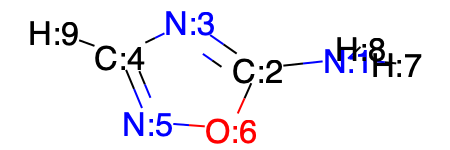

******************************************************************************************
rxn 012792 with smiles [O:1]([c+:2]1[n-:3][c:4]([O:5][H:9])[c:6]([H:10])[n:7]1[H:11])[H:8] had neighboring formal charges


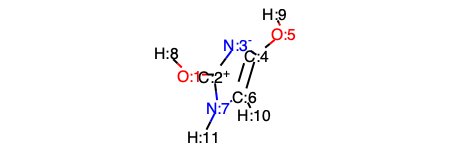

Propose adding a double bond instead as [O:1]([c:2]1[n:7]([H:11])[c:6]([H:10])[c:4]([O:5][H:9])[n:3]=1)[H:8]


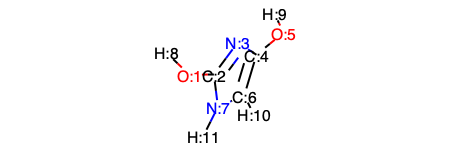

******************************************************************************************


In [8]:
bad_rsmi_idx = []
failed_embedding_idx = []
for i, rsmi in enumerate(df_colin_unique.rsmi.values):
    num_reactants = len(rsmi.split('.'))
    if num_reactants == 1:
        idx = df_colin_unique.idx.values[i]
        out = look_for_adjacent_charges(rsmi, idx)
        if out:
            bad_rsmi_idx.append(f'{out:06}')

In [9]:
bad_rsmi_idx

['000013', '000026', '002861', '012792']

In [10]:
failed_embedding_idx

[]

Change smiles for rxn000026, rxn002861, and rxn012792
Unfortunately, RDKit does not always preserve the atom mapping when proposing a new smiles... so manually edit those here...


But if we do sanitize, the proposed smiles often is wrong.. notice the second molecule has the wrong atom mapping...

In [12]:
def create_rdkit_mol(smiles):
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    mol = Chem.AddHs(mol)
#     out = AllChem.EmbedMolecule(mol, maxAttempts=5000)
    [a.SetAtomMapNum(a.GetIdx()+1) for a in mol.GetAtoms()]
    display(mol)
    
    return mol

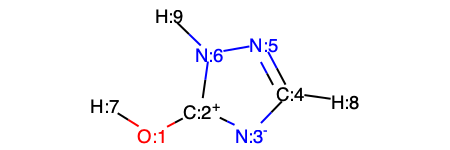

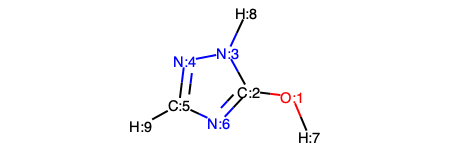

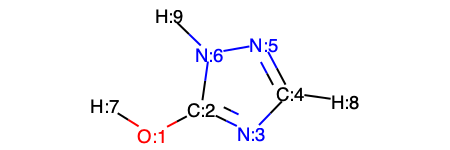

In [14]:
# rxn000026
# original
smiles = '[O:1]([c+:2]1[n-:3][c:4]([H:8])[n:5][n:6]1[H:9])[H:7]'
mol1 = create_rdkit_mol(smiles)

# proposed
smiles = '[O:1]([c:2]1[n:6]([H:9])[n:5][c:4]([H:8])[n:3]=1)[H:7]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[O:1]([c:2]1=[n:3][c:4]([H:8])[n:5][n:6]1[H:9])[H:7]'
mol3 = create_rdkit_mol(smiles)

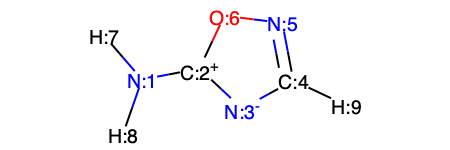

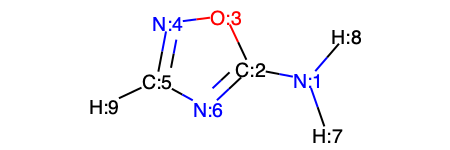

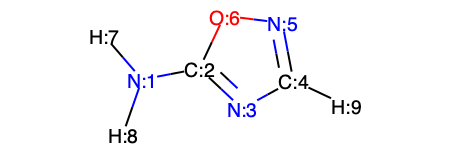

In [16]:
# rxn002861
# original
smiles = '[N:1]([c+:2]1[n-:3][c:4]([H:9])[n:5][o:6]1)([H:7])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, has the wrong atom mapping
smiles = '[N:1]([c:2]1[o:6][n:5][c:4]([H:9])[n:3]=1)([H:7])[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[N:1]([c:2]1=[n:3][c:4]([H:9])[n:5][o:6]1)([H:7])[H:8]'
mol3 = create_rdkit_mol(smiles)

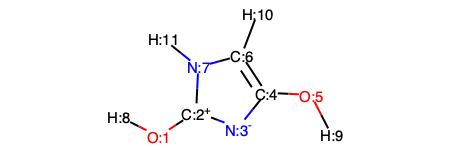

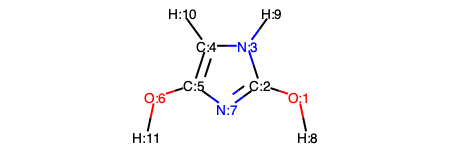

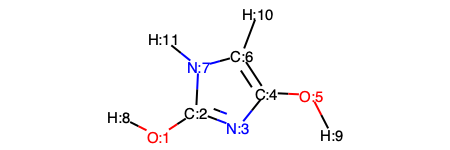

In [18]:
# rxn012792
# original
smiles = '[O:1]([c+:2]1[n-:3][c:4]([O:5][H:9])[c:6]([H:10])[n:7]1[H:11])[H:8]'
mol1 = create_rdkit_mol(smiles)

# proposed, has the wrong atom mapping
smiles = '[O:1]([c:2]1[n:7]([H:11])[c:6]([H:10])[c:4]([O:5][H:9])[n:3]=1)[H:8]'
mol2 = create_rdkit_mol(smiles)

# cleaned
smiles = '[O:1]([c:2]1=[n:3][c:4]([O:5][H:9])[c:6]([H:10])[n:7]1[H:11])[H:8]'
mol3 = create_rdkit_mol(smiles)